In [0]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import os

path = '/content/drive/My Drive/Colab Notebooks/Udemy/fruits-360'
os.chdir(path)
os.listdir()

# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs, batch_size = 5, 32

# https://www.kaggle.com/paultimothymooney/blood-cells
# train_path = '../large_files/blood_cell_images/TRAIN'
# valid_path = '../large_files/blood_cell_images/TEST'

# https://www.kaggle.com/moltean/fruits
# train_path = '../fruits-360/fruits-360_dataset/Training'
# test_path = '../fruits-360/fruits-360_dataset/Test'
train_path = '../fruits-360/fruits-360_reduced/Training'
test_path  = '../fruits-360/fruits-360_reduced/Test'

imgs_train = glob( train_path + '/*/*.jp*g')
imgs_test  = glob( test_path  + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

In [0]:
# look at an image for fun
# plt.imshow(image.img_to_array(image.load_img(np.random.choice(train_imgs))).astype('uint8'))
plt.imshow(image.img_to_array(image.load_img(np.random.choice(imgs_train))).astype('uint8'))
plt.show()

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop', metrics=['accuracy'])

# create an instance of ImageDataGenerator (helps with generalization)
gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
  height_shift_range=0.1, shear_range=0.1, zoom_range=0.2, horizontal_flip=True,
  vertical_flip=True, preprocessing_function=preprocess_input)

Found 1123 images belonging to 7 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Peach': 6}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -105.07506 max: 151.061


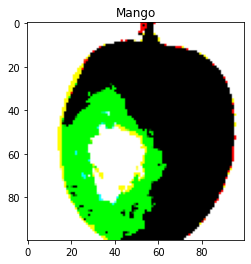

Found 3349 images belonging to 7 classes.
Found 1123 images belonging to 7 classes.


In [0]:
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(test_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

# create generators --> colours should be weird because VGG was trained by BGR (!)
train_generator = gen.flow_from_directory( train_path, target_size=IMAGE_SIZE, shuffle=True, batch_size=batch_size)
valid_generator = gen.flow_from_directory(  test_path, target_size=IMAGE_SIZE, shuffle=True, batch_size=batch_size)

In [0]:
# fit the model
r = model.fit_generator( train_generator, validation_data=valid_generator,
  epochs=epochs, steps_per_epoch=len(imgs_train) // batch_size,
  validation_steps=len(imgs_test) // batch_size)

def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm



NameError: ignored

In [0]:
# ----------- Confustion matrix ------------ #
cm = get_confusion_matrix(train_path, len(imgs_train))
print(cm)
valid_cm = get_confusion_matrix(test_path, len(imgs_test))
print(valid_cm)

# ----------- Data visualization ----------- #
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

from sklearn.metrics import plot_confusion_matrix as p_mat
p_mat(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')


NameError: ignored